In [ ]:
import datetime
import functools
import gc
import os
import random
from bisect import bisect_right
from time import time

import numpy as np
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [ ]:
! pip install tensorflow_addons

import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow_datasets as tfds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -e git+https://github.com/tensorflow/similarity.git@cars196#egg=tensorflow_similarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining tensorflow_similarity from git+https://github.com/tensorflow/similarity.git@cars196#egg=tensorflow_similarity
  Updating ./src/tensorflow-similarity clone (to revision cars196)
  Running command git fetch -q --tags
  Running command git reset --hard -q 3b3e4d624508d4ee953a08ce2e5928f6c60526d8
  Attempting uninstall: tensorflow-similarity
    Found existing installation: tensorflow-similarity 0.16.6
    Can't uninstall 'tensorflow-similarity'. No files were found to uninstall.
  Running setup.py develop for tensorflow-similarity


In [ ]:
import tensorflow_similarity as tfsim

In [ ]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

In [ ]:
import gc

# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
# MODEL_NAME = 'inception_v3'
MODEL_NAME = "resnet50"

In [ ]:
import functools

In [ ]:
ds, data_info = tfds.load("cars196", split="all", with_info=True, as_supervised=True)
# num_examples_train = data_info.splits["train"].num_examples
# num_examples_test = data_info.splits["test"].num_examples
total_num_classes = data_info.features["label"].num_classes

training_classes = total_num_classes
examples_per_class_per_batch = 5

batch_size = 80
classes_per_batch = batch_size // examples_per_class_per_batch  # 16 classes per batch
origin_img_size = 256
target_img_size = 227
area_range = [0.16, 1.0]

train_cls = list(range(196 // 2))
test_cls = list(range(196 // 2, 196))

print(f"Class IDs seen during training {train_cls}")


def torchvision_resize(img, origin_size):
    """Pytorch resize sets the image's smallest side to the origin_size.

    This will yield a list of tensors of different sizes and requires using the modified sampler.
    """
    img_shape = tf.shape(img)
    aspect_ratio = img_shape[0] / img_shape[1]
    if img_shape[0] < img_shape[1]:
        height = origin_size
        width = tf.cast(tf.cast(img_shape[1], dtype=tf.float64) * (img_shape[0] / origin_size), dtype=tf.int32)
    else:
        height = tf.cast(tf.cast(img_shape[0], dtype=tf.float64) * (img_shape[1] / origin_size), dtype=tf.int32)
        width = origin_size
    return tf.image.resize(img, [height, width], preserve_aspect_ratio=True)


def preprocess(img, y, *args, origin_size, model_name="resnet50"):
    with tf.device("/cpu:0"):
        img = torchvision_resize(img, origin_size)
        if model_name == "resnet50":
            img = tf.keras.applications.resnet50.preprocess_input(img)
        elif model_name == "inception_v3":
            img = tf.keras.applications.inception_v3.preprocess_input(img)
        else:
            raise ValueError(f"{model_name} is not a supported name")

    return img, y


def train_augmentation(img_batch, y, *args, target_size, area_range):
    aug_imgs = []
    for img in img_batch:
        crop_area = tf.random.uniform(shape=(1, 1), minval=0.15, maxval=1.0)
        start_y = tf.random.uniform(shape=(1, 1), minval=0.0, maxval=1 - crop_area)
        start_x = tf.random.uniform(shape=(1, 1), minval=0.0, maxval=1 - crop_area)
        start_yx = tf.concat((start_y, start_x), axis=1)
        end_yx = start_yx + crop_area
        boxes = tf.concat((start_yx, end_yx), axis=1)
        box_indicies = tf.range(1)

        # random crop
        img = tf.image.crop_and_resize(tf.expand_dims(img, axis=0), boxes, box_indicies, (target_size, target_size))

        # random horizontal flip
        img = tf.image.random_flip_left_right(img)
        aug_imgs.append(img[0])

    return tf.convert_to_tensor(np.array(aug_imgs)), y


def test_augmentation(img_batch, y, *args, origin_size, target_size):
    aug_imgs = []
    for img in img_batch:
        img = tf.image.central_crop(img, target_size / origin_size)
        img = tf.keras.layers.Resizing(target_size, target_size, crop_to_aspect_ratio=True)(img)
        aug_imgs.append(img)

    return tf.convert_to_tensor(np.array(aug_imgs)), y


def filter_by_class(ds, class_list):
    # Filter for classes in class list
    ds = ds.filter(lambda x, y: tf.math.reduce_any(tf.equal(y, class_list)))
    # Unpack a list of (x, y) into (X), (Y)
    ds = zip(*tfds.as_numpy(ds))
    # Convert the iterator into a tuple
    return tuple(ds)


ds = ds.map(lambda x, y: preprocess(x, y, origin_size=origin_img_size, model_name=MODEL_NAME))
(train_x, train_y) = filter_by_class(ds, train_cls)
(test_x, test_y) = filter_by_class(ds, test_cls)


# use the train split for training
train_ds = tfsim.samplers.memory_samplers.RaggedMultiShotMemorySampler(
    x=train_x,
    y=train_y,
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    class_list=train_cls,
    augmenter=functools.partial(
        train_augmentation,
        target_size=target_img_size,
        area_range=area_range,
    ),
)  # We filter train data to only keep the train classes.

# use the test split for indexing and querying
test_ds = tfsim.samplers.memory_samplers.RaggedMultiShotMemorySampler(
    x=test_x,
    y=test_y,
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    augmenter=functools.partial(
        test_augmentation,
        origin_size=origin_img_size,
        target_size=target_img_size,
    ),
)

num_examples_train = len(train_ds._y)
num_examples_test = len(test_ds._y)

Class IDs seen during training [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]

The initial batch size is 80 (16 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8054 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/98 [00:00<?, ?it/s]

gather examples:   0%|          | 0/8054 [00:00<?, ?it/s]

/content/src/tensorflow-similarity/tensorflow_similarity/samplers/utils.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(batch_x), np.array(batch_y)


indexing classes:   0%|          | 0/8054 [00:00<?, ?it/s]


The initial batch size is 80 (16 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/8131 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/98 [00:00<?, ?it/s]

gather examples:   0%|          | 0/8131 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/8131 [00:00<?, ?it/s]

In [ ]:
# USE THIS TO CHECK PYTORCH IMAGE TRANSFORMS

# from PIL import Image
# import torchvision.transforms as T

# for img, y in ds.take(2).as_numpy_iterator():
#     img = Image.fromarray(img)
#     img = T.Resize(size=256)(img)
#     #plt.imshow(img)
#     img = T.RandomResizedCrop(scale=(0.16, 1.), size=227)(img)
#     plt.imshow(img)
#     # print(np.asarray(img))

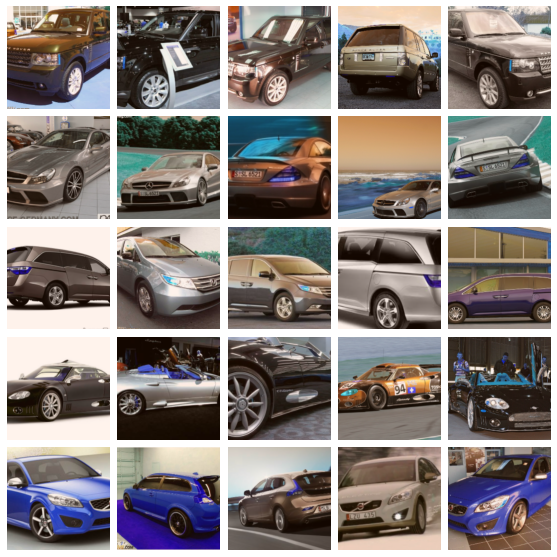

In [ ]:
num_cols = num_rows = 5
# Get the first 25 examples.
(x_batch, y_batch) = test_ds.generate_batch(0)
x_slice = x_batch[0 : num_cols * num_rows]
y_slice = y_batch[0 : num_cols * num_rows]

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

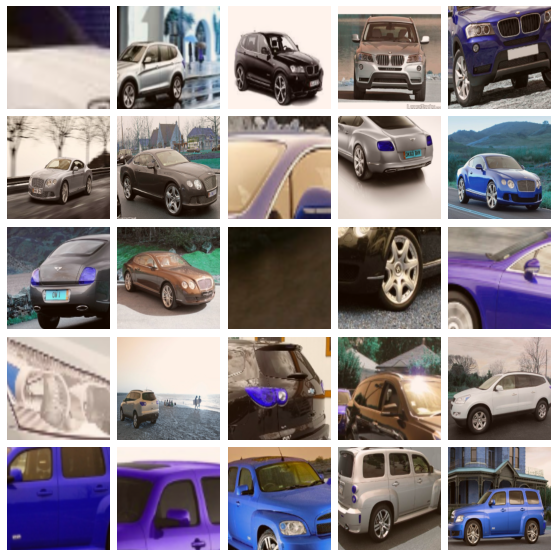

In [ ]:
num_cols = num_rows = 5
# Get the first 25 examples.
(x_batch, y_batch) = train_ds.generate_batch(0)
x_slice = x_batch[0 : num_cols * num_rows]
y_slice = y_batch[0 : num_cols * num_rows]

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

In [ ]:
def generate_eval_data(test_ds, num_queries_per_class, num_index_per_class, class_list):
    q_x, q_y = [], []
    i_x, i_y = [], []

    # get example for each class
    q_idxs = []
    i_idxs = []
    total_samples = num_queries_per_class + num_index_per_class
    for class_id in class_list:
        class_idxs = test_ds.index_per_class[class_id]
        if len(class_idxs) < total_samples:
            print(
                f"warning: Class {class_id} only has {len(class_idxs)} examples but "
                f"{total_samples} were requested. Using choices instead of sample."
            )
            sampled_idxs = random.choices(class_idxs, k=total_samples)
        else:
            sampled_idxs = random.sample(class_idxs, k=total_samples)

        q_idxs.extend(sampled_idxs[:num_queries_per_class])
        i_idxs.extend(sampled_idxs[num_queries_per_class:])

    # strip examples if needed. This might happen due to rounding
    for idx in q_idxs:
        q_x.append(test_ds._x[idx])
        q_y.append(test_ds._y[idx])

    for idx in i_idxs:
        i_x.append(test_ds._x[idx])
        i_y.append(test_ds._y[idx])

    return (
        np.array(q_x),
        np.array(q_y),
        np.array(i_x),
        np.array(i_y),
    )

In [ ]:
num_queries_per_class = 10
num_index_per_class = 32
k = 1

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y, targets_x, targets_y = generate_eval_data(test_ds, num_queries_per_class, num_index_per_class, test_cls)

queries_x, queries_y = test_augmentation(
    queries_x,
    queries_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)
targets_x, targets_y = test_augmentation(
    targets_x,
    targets_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)

# Setup SplitValidation callback.
val_loss = tfsim.callbacks.EvalCallback(
    queries_x,
    tf.cast(queries_y, dtype=tf.dtypes.int32),
    targets_x,
    tf.cast(targets_y, dtype=tf.dtypes.int32),
    metrics=["f1", "binary_accuracy"],
    # known_classes=tf.constant(train_cls),
    k=k,
)

logdir = os.path.join("logs_cars", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)
tbc = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    val_loss,
    tbc,
]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


logs_cars/20220714-051923


In [ ]:
EMBEDDING_SIZE = 512
INPUT_SHAPE = (target_img_size, target_img_size, 3)

# building model
if MODEL_NAME == "resnet50":
    model = tfsim.architectures.ResNet50Sim(
        input_shape=INPUT_SHAPE,
        embedding_size=EMBEDDING_SIZE,
        weights="imagenet",
        trainable="full",
        include_top=True,
        l2_norm=True,
        pooling="avg",
    )
elif MODEL_NAME == "inception_v3":
    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
    x = inputs
    x = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights="imagenet", pooling="avg")(x)
    outputs = tfsim.layers.MetricEmbedding(EMBEDDING_SIZE)(x)
    model = tfsim.models.SimilarityModel(inputs, outputs)
    for l in model.layers:
        if l.name == "inception_v3":
            for il in l.layers:
                if isinstance(il, tf.keras.layers.BatchNormalization):
                    il.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# UNCOMMENT TO CHECK THE TRAINABLE STATE OF EACH LAYER IN THE MODEL

# for layer in model.layers:
#     if layer.name == MODEL_NAME:
#         for rl in layer.layers:
#             print(
#                 f"{rl.name} | {rl.trainable} | weights: {len(rl.weights)} | trainable_weights: {len(rl.trainable_weights)} | non_trainable_weights: {len(rl.non_trainable_weights)}"
#             )
#     else:
#         print(
#             f"{layer.name} | {layer.trainable} | weights: {len(layer.weights)} | trainable_weights: {len(layer.trainable_weights)} | non_trainable_weights: {len(layer.non_trainable_weights)}"
#         )

In [ ]:
steps_per_epoch = 20
epochs = 3000 // steps_per_epoch
validation_steps = num_examples_test // batch_size
steps_decay = [1200, 2400]

loss_type = "multi-similarity"

# TODO: add links to all the papers and where losses were referenced
distance = "cosine"
if loss_type == "multi-similarity":
  # init similarity loss
  loss = tfsim.losses.MultiSimilarityLoss(
      distance=distance, alpha=2.0, beta=40.0, epsilon=0.1, lmda=0.5, center=1.0)
elif loss_type ==  "circle-loss":
  loss = tfsim.losses.CircleLoss(
      distance=distance,
      gamma=256,
      margi=0.2
  )
elif loss_type == "pn-loss":
  loss = tfsim.losses.PNLoss(
      distance=distance
      #TODO: what other parameters should be configured?
  )
elif loss_type == "triplet-loss":
  loss = tfsim.losses.TripletLoss(
      distance=distance,
      # TODO: where can I find details of parameters margins, etc...
  )
elif loss_type == "xbm-loss":
  loss = tfsim.losses.xbm_loss.XBM(
      memory_size=100, # What is this value?
      warmup_steps=1000 # retrieved from paper, is it correct?
  )
elif loss_type == "soft-nn":
  loss = tfsim.losses.softnn_loss.SoftNearestNeighborLoss(
      distance="cosine",
      temperature=100
  )
else:
  raise Exception("Invalid loss type")


# # THE STEP IS NEEDED WHEN PASSING lr TO THE OTHER TF ADD ONS OPTIMIZERS
lr_milestones = [3e-05, 3e-06, 3e-07, 3e-08]
lr_schedule_main = tf.optimizers.schedules.PiecewiseConstantDecay(steps_decay, lr_milestones[:3])
lr_schedule_backbone = tf.optimizers.schedules.PiecewiseConstantDecay(steps_decay, lr_milestones[1:])

# SO FAR ADAM GETS US THE CLOSEST TO THE PAPER RESULTS
# # Adam
# optimizer_main = tf.keras.optimizers.Adam(
#     learning_rate=lr_schedule_main,
#     beta_1=0.9,
#     beta_2=0.999,
# )

# optimizer_backbone = tf.keras.optimizers.Adam(
#     learning_rate=lr_schedule_backbone,
#     beta_1=0.9,
#     beta_2=0.999,
# )

# THE FOLLOWING CAN BE USED FOR WEIGHT DECAY SCHEDULE
wd_milestones = [5e-04, 5e-05, 5e-06, 5e-07]
wd_schedule_main = tf.optimizers.schedules.PiecewiseConstantDecay(steps_decay, wd_milestones[:3])
wd_schedule_backbone = tf.optimizers.schedules.PiecewiseConstantDecay(steps_decay, wd_milestones[1:])

# # AdamW 
optimizer_main = tfa.optimizers.AdamW(
    learning_rate=lr_schedule_main,
    weight_decay=lambda: None,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
)
optimizer_main.weight_decay = lambda: wd_schedule_main(optimizer_main.iterations)

optimizer_backbone = tfa.optimizers.AdamW(
    learning_rate=lr_schedule_backbone,
    weight_decay=lambda: None,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
)
optimizer_backbone.weight_decay = lambda: wd_schedule_backbone(optimizer_backbone.iterations)

# # LAMB
# optimizer_main = tfa.optimizers.LAMB(
#     learning_rate=lr_schedule_main,
#     beta_1=0.9,
#     beta_2=0.999,
#     exclude_from_weight_decay=['bn'],
# )

# optimizer_backbone = tfa.optimizers.LAMB(
#     learning_rate=lr_schedule_backbone,
#     beta_1=0.9,
#     beta_2=0.999,
#     exclude_from_weight_decay=['bn'],
# )



# The benchmark repo sets the LR on the backbone to 0.1 * the LR on the embedding layers.
optimizers_and_layers = [
    (optimizer_backbone, model.layers[0]),
    (optimizer_backbone, model.layers[1]),
    (optimizer_main, model.layers[2:]),
]

optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers=optimizers_and_layers)

# compiling and training
model.compile(optimizer=optimizer, loss=loss)

Distance metric automatically set to cosine use the distance arg to override.


In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

Epoch 1/150
20/20 [==============================] - ETA: 0s - loss: 0.9879Warmup complete
f1: 0.4747 - binary_accuracy: 0.3112
20/20 [==============================] - 143s 6s/step - loss: 0.9879 - val_loss: 0.9479 - f1: 0.4747 - binary_accuracy: 0.3112
Warmup complete
Epoch 2/150
20/20 [==============================] - 112s 6s/step - loss: 0.9604 - val_loss: 0.9293 - f1: 0.5015 - binary_accuracy: 0.3347
Epoch 3/150
20/20 [==============================] - 112s 6s/step - loss: 0.9429 - val_loss: 0.9129 - f1: 0.5230 - binary_accuracy: 0.3541
Epoch 4/150
20/20 [==============================] - 112s 6s/step - loss: 0.9365 - val_loss: 0.9095 - f1: 0.5196 - binary_accuracy: 0.3510
Epoch 5/150
20/20 [==============================] - 112s 6s/step - loss: 0.9300 - val_loss: 0.9059 - f1: 0.5460 - binary_accuracy: 0.3755
Epoch 6/150
20/20 [==============================] - 112s 6s/step - loss: 0.9311 - val_loss: 0.9039 - f1: 0.5481 - binary_accuracy: 0.3776
Epoch 7/150
20/20 [===============

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name}")
plt.show()

In [ ]:
num_queries_per_class = 19
num_index_per_class = 30

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y, targets_x, targets_y = generate_eval_data(test_ds, num_queries_per_class, num_index_per_class, test_cls)

queries_x, queries_y = test_augmentation(
    queries_x,
    queries_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)
targets_x, targets_y = test_augmentation(
    targets_x,
    targets_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)


model.reset_index()
model.index(targets_x, targets_y)

In [ ]:
calibration_results = model.calibrate(queries_x, queries_y)

In [ ]:
recall_metrics = [tfsim.retrieval_metrics.RecallAtK(k=i) for i in (1, 2, 4, 8, 16, 32)]
prec_metrics = [tfsim.retrieval_metrics.PrecisionAtK(k=i) for i in (1, 2, 4, 8, 16, 32)]
dist_thresh = np.round(calibration_results.cutpoints["optimal"]["distance"], 4)
bndcg_metrics = [tfsim.retrieval_metrics.BNDCG(k=i, distance_threshold=dist_thresh) for i in (1, 2, 4, 8, 16, 32)]

model.evaluate_retrieval(queries_x, queries_y, recall_metrics + prec_metrics + bndcg_metrics);